# MNIST 데이터 세트
- 머신러닝을 위한 이미지 데이터 세트의 예제

In [ ]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, y_train.shape

11490434/11490434 [==============================] - 2s 0us/step


((60000, 28, 28), (60000,))

## 시각화

In [ ]:
# 첫 번째 이미지 가져오기
image = X_train[0]
print(image.shape)

(28, 28)


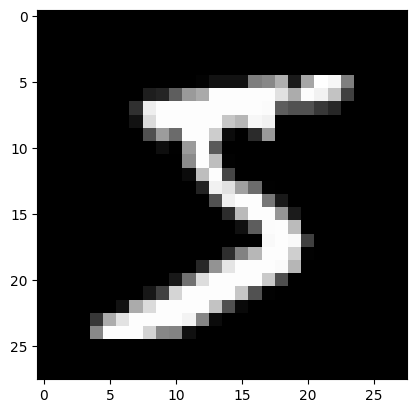

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
import pandas as pd

pd.DataFrame(image).style.background_gradient(cmap='gray')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0


# Fully Connected Layer 만들기
* 레이어들은 `tf.keras.layers` 패키지에 모두 들어 있다.
* `Flatten Layer` : 배치(BATCH)를 제외한 평탄화 담당
  * `numpy` 할 때는 `reshape`, 배치 개수 따로 빼고 해야 했는데, 여기선 그럴 필요가 없다.
* `Dense Layer` : `Affine`연산(신경망의 행렬 내적 계산). **Fully Connected**
  * `Dense Layer` 파라미터에 `activation`을 지정 가능
* `Activation Layer` : 활성화 함수 레이어(선택에 따라서 사용을 안할 수도 있다.)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation

# Sequential 모델을 만들 때는 리스트에 레이어를 쌓아놓기만 하면 된다.
model = Sequential([
    Input(shape=(28, 28)), # 입력층. 배치 크기(N)를 제외한 나머지 데이터의 shape 입력
    Flatten(), # 평탄화 층. 배치 사이즈를 제외한 나머지 차원을 평탄화

    # Fully Connected 구성

    #### HIDDEN LAYER ####
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    ######################

    # 출력층. 숫자는 0 ~ 9 까지 10개 이므로 출력층의 뉴런의 개수는 10개, ACTIVATION FUNCTION은 SOFTMAX
    # 출력층 숫자 = 분류되길 원하는 클래스 종류 (개수)
    Dense(10, activation='softmax')
])

# 모델 요약
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               401920    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
Total params: 575,050
Trainable params: 575,050
Non-tr

# 최적화 계획 세우기 - 컴파일
* `Loss Function`(손실 함수) - MSE, CEE를 쓸지를 결정
* `Optimization`(최적화 함수) - SGD, ADAM, RMSProps 등을 지정
  * 거의 대부분 ADAM, RMSProps 등을 기본으로 사용
* `Metrics` - 테스트 세트에 대한 평가 기준
  * `acc`, `recall`, `precision`

## Loss Function 선정 기준
* 이진 분류를 수행하는 경우(Binary Classification)
  * `mse` : 출력층의 뉴런이 1개인 경우 - with `sigmoid`
  * `cross entropy error` : 출력층의 뉴런이 2개인 경우 - with `softmax` ( 제일 자주 사용되는 방법 )
    * **`binary_crossentropy`**를 사용하면 된다.
* 다중 분류를 수행하는 경우(Multiclass Classification)
  * `cross entropy error` : 출력층의 뉴런을 클래스의 개수만큼 설정
    * **`categorical_crossentropy`**를 사용하면 된다.

### Categorical Cross Entropy의 종류
  * Label이 `[0, 1, 2]` 처럼 One-Hot Encoding이 되어있지 않은 경우
    * **`sparse_categorical_crossentropy`**를 사용
  * Label이 One-Hot Encoding이 되어있는 경우
    * **`categorical_crossentropy`**를 사용

y_train을 확인해서 어떤 Loss Function을 사용할지 결정

In [ ]:
y_train.shape

(60000,)

In [ ]:
y_train[:3]

array([5, 0, 4], dtype=uint8)

y_train 확인한 결과 OHE 되어있지 않은 상태. `sparse_categorical_crossentropy`를 활용하거나, y_train을 One Hot Encoding 한 다음 `categorical_crossentropy`를 사용하면 된다.

In [ ]:
# loss function
loss_func = tf.keras.losses.sparse_categorical_crossentropy
loss_func

<function keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False, axis=-1, ignore_class=None)>

In [ ]:
# y_train이 OHE이 되어 있으면 categorical_crossentropy
tf.keras.losses.categorical_crossentropy

<function keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)>

In [ ]:
# 이진 분류라면?
tf.keras.losses.binary_crossentropy

<function keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)>

## Optimizer 설정
* `sgd` - `tf.keras.optimizers.SGD()`
* `rmsprops` - `tf.keras.optimizers.RMSprop()`
* `adam` - `tf.keras.optimizers.Adam()` - 일반적으로 제일 많이 사용하는 최적화 기법, 뭘 쓸지 모르겠다면 `adam`을 선택하세요

In [ ]:
optm = tf.keras.optimizers.Adam()
optm

## Metrics 설정
- 테스트(검증) 세트 평가 방법
- 훈련에 영향을 미치는 것이 아닌, 확인 용도의 설정
- 일반적으로는 정확도로 설정
  - `accuracy`, `acc` 중 하나로 설정.


In [ ]:
metrics = ['acc']

In [ ]:
# 훈련 수행 전에 모델에 손실함수, 최적화방법, 평가방법을 적용
model.compile(
    optimizer = optm,
    loss = loss_func,
    metrics = metrics
)

# 훈련

In [ ]:
# 훈련용 하이퍼 파라미터 설정
# 에폭, 배치크기
num_epochs = 10
batch_size = 32

model.fit(
    X_train, # 훈련 X 데이터(feature)
    y_train, # 훈련 y 레이블(target)
    batch_size=batch_size,
    epochs=num_epochs,
    shuffle=True, # 데이터를 섞어 가면서 복잡하게 훈련
    validation_split=0.2 # 전체 훈련 데이터 중 검증 세트로 사용할 크기의 비율
)

Epoch 1/10
1500/1500 [==============================] - 16s 4ms/step - loss: 0.7635 - acc: 0.8857 - val_loss: 0.2233 - val_acc: 0.9423
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1887 - acc: 0.9485 - val_loss: 0.1784 - val_acc: 0.9518
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1450 - acc: 0.9585 - val_loss: 0.1558 - val_acc: 0.9570
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1201 - acc: 0.9660 - val_loss: 0.1439 - val_acc: 0.9623
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1125 - acc: 0.9688 - val_loss: 0.1602 - val_acc: 0.9600
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0918 - acc: 0.9743 - val_loss: 0.1305 - val_acc: 0.9665
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0843 - acc: 0.9764 - val_loss: 0.1362 - val_acc: 0.9628
Epoch 8/10
1500/1500 [==============================] - 6s 4m

# 최종 평가
- Test 세트로 평가

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.1133 - acc: 0.9721


[0.11333739012479782, 0.972100019454956]